In [9]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
from scipy.stats import sem

parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), "general_utils"))
# import file_management
from v1_model_utils import models, load_sparse, other_v1_utils
sys.path.append(os.path.join(os.getcwd(), "v1_model_utils"))
import analysis_utils as utils
from math import pi

import h5py
import pickle as pkl
from scipy.ndimage import gaussian_filter
from numba import njit

%load_ext line_profiler

sns.set(style="ticks")
plt.rcParams['text.usetex'] = True

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## DATA LOADING

In [10]:
cache_path = "GLIF_network/tf_data/V1_network_v1_65870.pkl"
# cache_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/v1_model_utils/.cache/V1_network_v1_65871_random_weights_True.pkl'
with open(cache_path, "rb") as f:
    network, lgn_input, bkg_input = pkl.load(f)

# Extract main variables from the network
voltage_scale = (network["node_params"]["V_th"] - network["node_params"]["E_L"]).astype(
    np.float32
)
variable_key = f"sparse_recurrent_weights:0"
indices = network["synapses"]["indices"].astype(np.int32)
node_type_ids = network["node_type_ids"]

# Load the V1 data csv
v1_path = "Simulation_results/v1_65870/b_9y2s/v1_features_df.csv"
# v1_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871_random_weights_True/b_30wm/v1_features_df.csv'
v1_core_df = pd.read_csv(v1_path, sep=" ")

# Load the checkpoint
ckpt_path = "Simulation_results/v1_65870/b_9y2s/Best_model"
# ckpt_path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/Simulation_results/v1_65871_random_weights_True/b_30wm/Best_model'
checkpoint_directory = tf.train.latest_checkpoint(ckpt_path)
print(f"Restoring checkpoint from {checkpoint_directory}...")

# Build the model
model = models.create_model(
    network,
    lgn_input,
    bkg_input,
    seq_len=500,
    n_input=17400,
    n_output=2,
    cue_duration=40,
    dtype=tf.float32,
    input_weight_scale=1.0,
    dampening_factor=0.5,
    recurrent_dampening_factor=0.5,
    gauss_std=0.3,
    lr_scale=1.0,
    train_input=False,
    train_noise=True,
    train_recurrent=True,
    train_recurrent_per_type=False,
    neuron_output=False,
    batch_size=1,
    pseudo_gauss=False,
    use_state_input=True,
    return_state=True,
    hard_reset=False,
    add_metric=True,
    max_delay=5,
)

model.build((1, 1000, 17400))

Restoring checkpoint from Simulation_results/v1_65870/b_9y2s/Best_model/ckpt-922...
Creating the V1 column...
    > # Recurrent synapses: 22987793
    > # LGN input synapses 31266063
    > # BKG input synapses 263480


In [11]:
# Store the initial model variables that are going to be trained
model_variables_dict = {
    "Initial": {
        var.name: var.numpy().astype(np.float16) for var in model.trainable_variables
    }
}
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_directory).expect_partial()  # .assert_consumed()
model_variables_dict["Restored"] = {
    var.name: var.numpy().astype(np.float16) for var in model.trainable_variables
}
model_variables_dict

{'Initial': {'sparse_recurrent_weights:0': array([-0.1145, -0.1144, -0.1147, ..., -0.2727, -0.2727, -0.273 ],
        dtype=float16),
  'rest_of_brain_weights:0': array([0.388, 0.388, 0.388, ..., 0.548, 0.548, 0.548], dtype=float16)},
 'Restored': {'sparse_recurrent_weights:0': array([-0.     , -0.     , -0.01831, ..., -0.9927 , -0.458  , -0.9214 ],
        dtype=float16),
  'rest_of_brain_weights:0': array([0.594 , 0.5615, 0.6035, ..., 0.16  , 0.1593, 0.1578], dtype=float16)}}

In [12]:
# path = '/home/jgalvan/Desktop/Neurocoding/V1_GLIF_model/lgn_model/data/lgn_full_col_cells_120x80.csv'
# lgn_data = pd.read_csv(path, sep=' ')
# v1_neuron_id = 0
# # for v1_neuron_id in range(10):
# mask = lgn_input['indices'][:, 0] == v1_neuron_id
# lgn_ids = lgn_input['indices'][:, 1][mask]
# x, y = lgn_data['x'][lgn_ids].values, lgn_data['y'][lgn_ids].values
# plt.plot(x, y, 'o')
# plt.plot(network['x'][v1_neuron_id] * 70/1000 + 60, network['z'][v1_neuron_id] * 40/1000 + 40, 'ro')
# plt.xlim(0, 120)
# plt.ylim(0, 80)
# plt.show()

In [13]:
v1_pop_names = other_v1_utils.pop_names(network)
v1_cell_types = [
    other_v1_utils.pop_name_to_cell_type(pop_name) for pop_name in v1_pop_names
]
v1_ei = [n[0] for n in v1_pop_names]
v1_core_mask = other_v1_utils.isolate_core_neurons(
    network, n_selected_neurons=16400, data_dir="GLIF_network"
)
v1_core_indices = np.where(v1_core_mask)[0]
v1_core_df["tf_id"] = v1_core_indices

all_v1_neurons_df = pd.DataFrame(
    {
        "tf_id": np.arange(len(v1_pop_names)),
        "pop_name": v1_pop_names,
        "cell_type": v1_cell_types,
        "ei": v1_ei,
        "tuning_angle": network["tuning_angle"],
        "x": network["x"],
        "y": network["y"],
        "z": network["z"],
        "azimuth": network["x"] * 70 / 1000 + 60,
        "elevation": network["z"] * 40 / 1000 + 40,
    }
)

v1_df = pd.merge(all_v1_neurons_df, v1_core_df, on=["tf_id", "pop_name"], how="outer")
v1_df["area"] = "v1"
v1_df["region"] = np.where(v1_df["tf_id"].isin(v1_core_indices), "core", "annulus")

# can we set two indices: first the area and then the tf_id
v1_df.set_index(["area", "tf_id"], inplace=True)
# df.set_index('tf_id', inplace=True)
v1_df.dropna(subset=["preferred_angle"], inplace=True)

df = v1_df.loc["v1"]
df

,pop_name,cell_type,ei,tuning_angle,x,y,z,azimuth,elevation,node_id,max_mean_rate(Hz),preferred_angle,OSI,DSI,Ave_Rate(Hz),firing_rate_sp,region
tf_id,,,,,,,,,,,,,,,,,
5,i1Htr3a,L1 Htr3a,i,9.045226,60.492802,-82.713699,-160.017105,64.234497,33.599316,1.0,4.063008,6.603322,0.171093,0.098385,2.54375,1.450,core
6,i1Htr3a,L1 Htr3a,i,10.854271,16.662233,-87.953789,89.391914,61.166355,43.575676,2.0,4.261225,357.774673,0.100113,0.049856,3.33750,2.050,core
15,i1Htr3a,L1 Htr3a,i,27.135679,-76.880775,-86.953346,-27.484894,54.618347,38.900604,6.0,4.978333,38.165579,0.128730,0.071330,3.60000,1.350,core
21,i1Htr3a,L1 Htr3a,i,37.989948,162.672806,-95.019730,33.832710,71.387100,41.353310,7.0,5.542764,46.547103,0.084356,0.018058,4.52500,9.875,core
29,i1Htr3a,L1 Htr3a,i,52.462311,-41.889690,-95.300346,78.845764,57.067722,43.153831,9.0,4.882037,75.796841,0.099008,0.020638,3.92500,8.850,core
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65793,i6Sst,L6 SST,i,37.674419,4.457649,-769.297058,193.433548,60.312035,47.737343,16378.0,7.101491,255.767006,0.068340,0.017101,5.57500,12.600,core
65798,i6Sst,L6 SST,i,58.604652,-49.120216,-690.973389,-125.136787,56.561584,34.994530,16381.0,4.089709,99.129703,0.171457,0.103514,2.47500,11.025,core
65803,i6Sst,L6 SST,i,79.534882,-120.217987,-708.617493,-99.707039,51.584740,36.011719,16382.0,5.469517,78.866741,0.166367,0.242550,2.58125,5.700,core


In [14]:
# #take a sample of the df but keep it ordered
# df = df.sample(frac=0.1).sort_index()
# df

## FUNCTIONS TOOLKIT

In [15]:
@njit
def fast_indices_masking(indices, target_tf_ids, source_tf_ids):
    target_tf_ids_set = set(target_tf_ids)
    source_tf_ids_set = set(source_tf_ids)
    mask = np.zeros(indices.shape[0], dtype=np.bool_)
    for k in range(indices.shape[0]):
        i, j = indices[k]
        if i in target_tf_ids_set and j in source_tf_ids_set:
            mask[k] = True
    return mask

## PREFERRED VS TUNING ANGLE HISTOGRAM|

V1 Percentage of responsive neurons: 100.0
V1 Mean difference between preferred and estimated tuning angle: 5.650721411154417


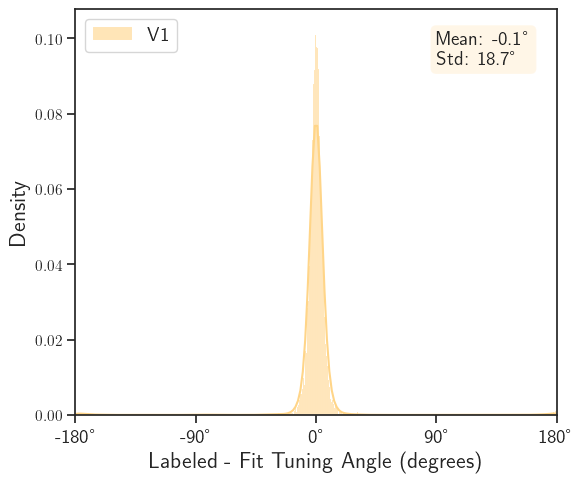

In [16]:
# plot an histogram with the variation of the tuning angle
v1_tuning_angles_diff = df["tuning_angle"] - df["preferred_angle"]
v1_responsive_neurons_mask = np.logical_not(np.isnan(v1_tuning_angles_diff))
v1_tuning_angles_diff = v1_tuning_angles_diff[v1_responsive_neurons_mask]
v1_tuning_angles_diff = np.where(
    v1_tuning_angles_diff > 180, v1_tuning_angles_diff - 360, v1_tuning_angles_diff
)
v1_tuning_angles_diff = np.where(
    v1_tuning_angles_diff < -180, v1_tuning_angles_diff + 360, v1_tuning_angles_diff
)
print(
    "V1 Percentage of responsive neurons:",
    np.sum(v1_responsive_neurons_mask) / len(v1_responsive_neurons_mask) * 100,
)
print(
    "V1 Mean difference between preferred and estimated tuning angle:",
    np.nanmean(np.abs(v1_tuning_angles_diff)),
)


def plot_tuning_angle_variation(V1_diff, path=""):

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Plot the first distribution
    V1_diff = V1_diff[~np.isnan(V1_diff)]
    NBR_BINS = utils.freedman_diaconis(V1_diff, returnas="bins")
    sns.histplot(
        V1_diff,
        bins=NBR_BINS,
        kde=True,
        ax=ax,
        color="#ffd588",
        label="V1",
        alpha=0.6,
        stat="density",
    )

    # Include as text the mean and std of the difference for each distribution
    box = dict(boxstyle="round", facecolor="#ffd588", alpha=0.2)
    ax.text(
        0.75,
        0.9,
        f"Mean: {np.mean(V1_diff):.1f}°\nStd: {np.std(V1_diff):.1f}°",
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=14,
        bbox=box,
    )

    # Customize the plot
    xticks = np.arange(-180, 181, 90)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x) + "°" for x in xticks], fontsize=14)
    # ax.set_yticks(list(ax.get_yticks().astype(int)))  # Set the ticks explicitly
    # ax.set_yticklabels(ax.get_yticks(), fontsize=14)  # Set the tick labels
    ax.set_xlim(-180, 180)
    ax.set_xlabel("Labeled - Fit Tuning Angle (degrees)", fontsize=16)
    ax.set_ylabel("Density", fontsize=16)
    # plt.title(f'{self.area}', fontsize=16)
    plt.legend(loc="upper left", fontsize=14)
    plt.tight_layout()
    plt.savefig(
        os.path.join(path, f"V1_tuning_angle_variation.png"), dpi=900, transparent=True
    )
    plt.show()


#     plt.close()

plot_tuning_angle_variation(v1_tuning_angles_diff, path="")

## WEIGHTS DISTRIBUTION IN TARGET NEURON COORDINATES

In [17]:
### DATA PREPARATION
cell_types = ["e", "i"]
source_cell_type = "e"
target_cell_type = "e"

# Select source and target IDs
source_tf_ids = df.index[df["ei"] == source_cell_type].astype(np.int32).values
target_tf_ids = (
    df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
    .astype(np.int32)
    .values
)
# Create sets for fast lookup
mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
selected_indices = indices[mask]
target_indices = selected_indices[:, 0]
source_indices = selected_indices[:, 1]
# Mask voltage_scale_node_ids first
voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
initial_value_masked = (
    model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
)
final_value_masked = (
    model_variables_dict["Restored"][variable_key][mask] * voltage_scale_node_ids
)
# Calculate tuning angle differences
target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
# Calculate differences in coordinates
source_azimuth = df.loc[source_indices, "azimuth"].values
target_azimuth = df.loc[target_indices, "azimuth"].values
source_elevation = df.loc[source_indices, "elevation"].values
target_elevation = df.loc[target_indices, "elevation"].values
# source position in the target centered coordinate system
diff_azimuth = source_azimuth - target_azimuth
diff_elevation = source_elevation - target_elevation
# get the target neuron angle to define the rotation
target_tuning_angle_rad = np.radians(target_tuning_angles)
cos_angles = np.cos(target_tuning_angle_rad)
sin_angles = np.sin(target_tuning_angle_rad)
# Rotate the sources coordinates according to the target neuron preferred direction
diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

/tmp/ipykernel_2719773/525629131.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


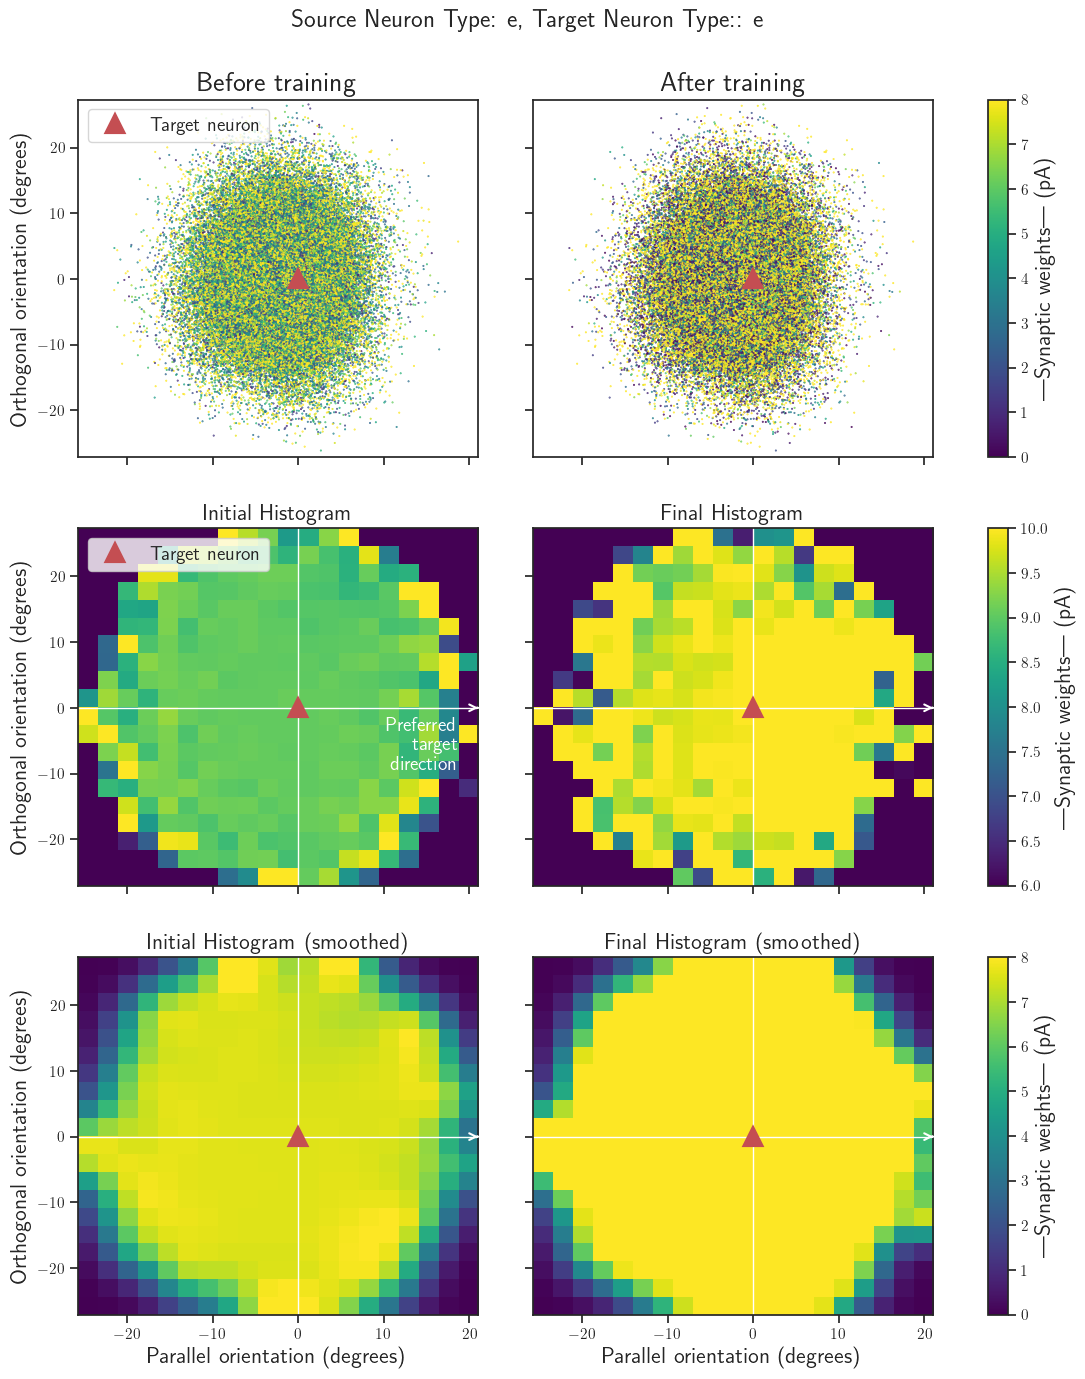

In [18]:
# Now represent the weights as a function of the difference in coordinates
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.2, hspace=0.2)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1], sharex=ax0, sharey=ax0)
# Randomly select indices to sample
n_samples = 100000
random_indices = np.random.choice(len(diff_x_rot), n_samples, replace=False)
# Initial scatter plot
scatter_initial = ax0.scatter(
    diff_x_rot[random_indices],
    diff_z_rot[random_indices],
    c=initial_value_masked[random_indices],
    cmap="viridis",
    s=0.2,
    alpha=1,
    vmin=0,
    vmax=8,
)
ax0.set_title("Before training", fontsize=20)
ax0.set_ylabel("Orthogonal orientation (degrees)", fontsize=16)
# Final scatter plot
scatter_final = ax1.scatter(
    diff_x_rot[random_indices],
    diff_z_rot[random_indices],
    c=final_value_masked[random_indices],
    cmap="viridis",
    s=0.2,
    alpha=1,
    vmin=0,
    vmax=8,
)
ax1.set_title("After training", fontsize=20)
scatter_cbar = plt.colorbar(scatter_final, cax=plt.subplot(gs[0, 2]))
scatter_cbar.set_label("|Synaptic weights| (pA)", fontsize=16)

# Create 2D histograms
bins = 20  # Number of bins in each dimension
# Initial histogram
H_initial, xedges_initial, yedges_initial = np.histogram2d(
    diff_x_rot, diff_z_rot, bins=bins, weights=initial_value_masked
)
count_initial, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins)
H_initial = np.divide(
    H_initial, count_initial, out=np.zeros_like(H_initial), where=count_initial != 0
)
# Final histogram
H_final, xedges_final, yedges_final = np.histogram2d(
    diff_x_rot, diff_z_rot, bins=bins, weights=final_value_masked
)
count_final, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins)
H_final = np.divide(
    H_final, count_final, out=np.zeros_like(H_final), where=count_final != 0
)

# Plot initial histogram with shared color scale
ax2 = plt.subplot(gs[1, 0], sharex=ax0, sharey=ax0)
im_initial = ax2.imshow(
    H_initial.T,
    origin="lower",
    extent=[
        xedges_initial[0],
        xedges_initial[-1],
        yedges_initial[0],
        yedges_initial[-1],
    ],
    aspect="auto",
    cmap="viridis",
    vmin=0,
    vmax=10,
)
ax2.set_title("Initial Histogram", fontsize=16)
ax2.set_ylabel("Orthogonal orientation (degrees)", fontsize=16)
# Plot final histogram with shared color scale
ax3 = plt.subplot(gs[1, 1], sharex=ax0, sharey=ax0)
im_final = ax3.imshow(
    H_final.T,
    origin="lower",
    extent=[xedges_final[0], xedges_final[-1], yedges_final[0], yedges_final[-1]],
    aspect="auto",
    cmap="viridis",
    vmin=6,
    vmax=10,
)
ax3.set_title("Final Histogram", fontsize=16)
cb_final = plt.colorbar(im_final, cax=plt.subplot(gs[1, 2]))
cb_final.set_label("|Synaptic weights| (pA)", fontsize=16)

# Apply Gaussian filter to histograms
sigma = 1  # Standard deviation for Gaussian kernel
H_initial_filtered = gaussian_filter(H_initial, sigma=sigma)
H_final_filtered = gaussian_filter(H_final, sigma=sigma)
# Plot initial histogram with Gaussian filter applied
ax4 = plt.subplot(gs[2, 0], sharex=ax0, sharey=ax0)
im_initial_filtered = ax4.imshow(
    H_initial_filtered.T,
    origin="lower",
    extent=[
        xedges_initial[0],
        xedges_initial[-1],
        yedges_initial[0],
        yedges_initial[-1],
    ],
    aspect="auto",
    cmap="viridis",
    vmin=0,
    vmax=8,
)
ax4.set_title("Initial Histogram (smoothed)", fontsize=16)
ax4.set_xlabel("Parallel orientation (degrees)", fontsize=16)
ax4.set_ylabel("Orthogonal orientation (degrees)", fontsize=16)
# Plot final histogram with Gaussian filter applied
ax5 = plt.subplot(gs[2, 1], sharex=ax0, sharey=ax0)
im_final_filtered = ax5.imshow(
    H_final_filtered.T,
    origin="lower",
    extent=[xedges_final[0], xedges_final[-1], yedges_final[0], yedges_final[-1]],
    aspect="auto",
    cmap="viridis",
    vmin=0,
    vmax=8,
)
ax5.set_title("Final Histogram (smoothed)", fontsize=16)
ax5.set_xlabel("Parallel orientation (degrees)", fontsize=16)
cb_final_filtered = plt.colorbar(im_final_filtered, cax=plt.subplot(gs[2, 2]))
cb_final_filtered.set_label(r"|Synaptic weights| (pA)", fontsize=16)
# Draw arrow and text for each subplot at y=0
for ax in [ax2, ax3, ax4, ax5]:
    ax.axvline(0, color="white", lw=1)
    ax.axhline(0, color="white", lw=1)
    ax.annotate(
        "",
        xy=(ax.get_xlim()[1], 0),
        xytext=(ax.get_xlim()[1] - 0.1, 0),
        arrowprops=dict(arrowstyle="->", color="white", lw=1.5),
    )
    if ax == ax2:
        # Position for the centered text at the right end of the x-axis
        x_right = x_right = ax.get_xlim()[1] - 0.05 * (
            ax.get_xlim()[1] - ax.get_xlim()[0]
        )  # Move left by 10% of x-axis range
        y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        ax.text(
            x_right,
            y_position,
            "Preferred \n target \n direction",
            color="white",
            ha="right",
            va="top",
            fontsize=14,
            weight="bold",
        )
# Hide y ticks for specific subplots (e.g., ax1, ax3, ax5)
for ax in [ax1, ax3, ax5]:
    ax.tick_params(axis="y", labelleft=False)
# Hide x ticks for specific subplots (e.g., ax0, ax1, ax2, ax3)
for ax in [ax0, ax1, ax2, ax3]:
    ax.tick_params(axis="x", labelbottom=False)

for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.plot(0, 0, "r^", markersize=12, markeredgewidth=3, label="Target neuron")
ax0.legend(loc="upper left", fontsize=14)
ax2.legend(loc="upper left", fontsize=14)

fig.suptitle(
    f"Source Neuron Type: {source_cell_type}, Target Neuron Type:: {target_cell_type}",
    fontsize=18,
)
fig.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

## WEIGHTS DISTRIBUTION FOR PARALLEL, PERPENDICULAR AND OPPOSITTE SOURCE NEURONS


e - e : Mean value of parallel histogram: 26.19976234436035
e - e : Mean value of perpendicular histogram: 4.816248416900635
e - e : Mean value of opposite histogram: 7.419114112854004

e - i : Mean value of parallel histogram: 23.572757720947266
e - i : Mean value of perpendicular histogram: 11.398242950439453
e - i : Mean value of opposite histogram: 9.557252883911133

i - e : Mean value of parallel histogram: 11.841741561889648
i - e : Mean value of perpendicular histogram: 7.014510631561279
i - e : Mean value of opposite histogram: 4.548513412475586

i - i : Mean value of parallel histogram: 15.883356094360352
i - i : Mean value of perpendicular histogram: 9.87217903137207
i - i : Mean value of opposite histogram: 7.110317230224609


/allen/programs/mindscope/workgroups/realistic-model/beatriz.herrera/miniconda3/envs/v1-SstTac1-model-PSS-tf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


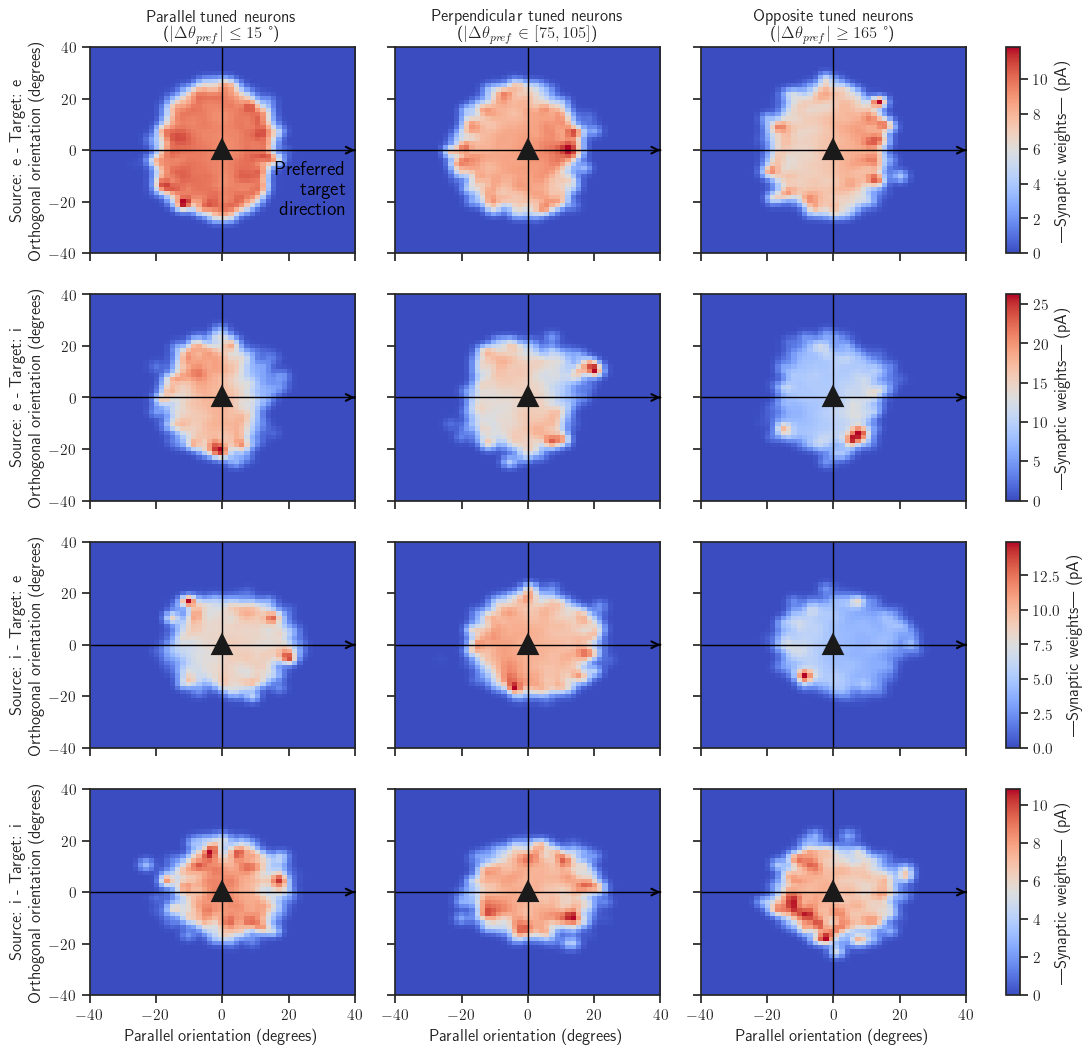

In [19]:
target_cell_types = ["e", "i"]
source_cell_types = ["e", "i"]

fig = plt.figure(figsize=(12, 6 * len(source_cell_types)), constrained_layout=True)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.85
gs = gridspec.GridSpec(
    len(source_cell_types) * len(target_cell_types),
    4,
    width_ratios=[1, 1, 1, 0.05],
    top=top_title_space,
    wspace=0.2,
    hspace=0.2,
)
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df['OSI'] > 0.2)].astype(np.int32).values
    source_tf_ids = (
        df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = np.abs(
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, "preferred_angle"].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, "azimuth"].values
        target_azimuth = df.loc[target_indices, "azimuth"].values
        source_elevation = df.loc[source_indices, "elevation"].values
        target_elevation = df.loc[target_indices, "elevation"].values
        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # get the target neuron angle to define the rotation
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles
        # Distinghish between parallel, orthogonal and opposite tuning angles
        # Parallel
        parallel_tuning_mask = tuning_angle_diff < 15
        parallel_diff_x = diff_x_rot[parallel_tuning_mask]
        parallel_diff_z = diff_z_rot[parallel_tuning_mask]
        parallel_final_value_masked = final_value_masked[parallel_tuning_mask]
        # parallel_final_value_masked = initial_value_masked[parallel_tuning_mask]

        # Orthogonal
        orthogonal_tuning_mask = np.logical_and(
            tuning_angle_diff > 80, tuning_angle_diff < 100
        )
        orthogonal_diff_x = diff_x_rot[orthogonal_tuning_mask]
        orthogonal_diff_z = diff_z_rot[orthogonal_tuning_mask]
        orthogonal_final_value_masked = final_value_masked[orthogonal_tuning_mask]
        # orthogonal_final_value_masked = initial_value_masked[orthogonal_tuning_mask]
        # Opposite
        opposite_tuning_mask = tuning_angle_diff > 165
        opposite_diff_x = diff_x_rot[opposite_tuning_mask]
        opposite_diff_z = diff_z_rot[opposite_tuning_mask]
        opposite_final_value_masked = final_value_masked[opposite_tuning_mask]
        # opposite_final_value_masked = initial_value_masked[opposite_tuning_mask]

        bins = 50
        area_dimensions = [[-40, 40], [-40, 40]]
        # area_dimensions = [[-10, 10], [-10, 10]]
        # Parallel
        H_parallel, xedges_parallel, yedges_parallel = np.histogram2d(
            parallel_diff_x,
            parallel_diff_z,
            bins=bins,
            range=area_dimensions,
            weights=parallel_final_value_masked,
        )
        count_parallel, _, _ = np.histogram2d(
            parallel_diff_x, parallel_diff_z, range=area_dimensions, bins=bins
        )
        H_parallel = np.divide(
            H_parallel,
            count_parallel,
            out=np.zeros_like(H_parallel),
            where=count_parallel != 0,
        )
        # Orthogonal
        H_perpendicular, xedges_perpendicular, yedges_perpendicular = np.histogram2d(
            orthogonal_diff_x,
            orthogonal_diff_z,
            bins=bins,
            range=area_dimensions,
            weights=orthogonal_final_value_masked,
        )
        count_perpendicular, _, _ = np.histogram2d(
            orthogonal_diff_x, orthogonal_diff_z, range=area_dimensions, bins=bins
        )
        H_perpendicular = np.divide(
            H_perpendicular,
            count_perpendicular,
            out=np.zeros_like(H_perpendicular),
            where=count_perpendicular != 0,
        )
        # Opposite
        H_opp, xedges_opp, yedges_opp = np.histogram2d(
            opposite_diff_x,
            opposite_diff_z,
            bins=bins,
            range=area_dimensions,
            weights=opposite_final_value_masked,
        )
        count_opp, _, _ = np.histogram2d(
            opposite_diff_x, opposite_diff_z, range=area_dimensions, bins=bins
        )
        H_opp = np.divide(
            H_opp, count_opp, out=np.zeros_like(H_opp), where=count_opp != 0
        )
        # Apply Gaussian filter to histograms
        sigma = 1
        H_parallel_filtered = gaussian_filter(H_parallel, sigma=sigma)
        H_perpendicular_filtered = gaussian_filter(H_perpendicular, sigma=sigma)
        H_opp_filtered = gaussian_filter(H_opp, sigma=sigma)
        # print the mean values of each histogram
        print()
        print(
            f"{source_cell_type} - {target_cell_type} : Mean value of parallel histogram: {np.mean(parallel_final_value_masked)}"
        )
        print(
            f"{source_cell_type} - {target_cell_type} : Mean value of perpendicular histogram: {np.mean(orthogonal_final_value_masked)}"
        )
        print(
            f"{source_cell_type} - {target_cell_type} : Mean value of opposite histogram: {np.mean(opposite_final_value_masked)}"
        )
        # Define limits of the histograms
        # global_min = 0
        # global_max = 30
        # Get the access for each subplot
        ax_parallel = plt.subplot(gs[plot_index, 0])
        ax_perpendicular = plt.subplot(
            gs[plot_index, 1], sharex=ax_parallel, sharey=ax_parallel
        )
        ax_opposite = plt.subplot(
            gs[plot_index, 2], sharex=ax_parallel, sharey=ax_parallel
        )

        im_parallel_filtered = ax_parallel.imshow(
            H_parallel_filtered.T,
            origin="lower",
            extent=[
                xedges_parallel[0],
                xedges_parallel[-1],
                yedges_parallel[0],
                yedges_parallel[-1],
            ],
            aspect="auto",
            cmap="coolwarm",
        )  # , vmin=global_min, vmax=global_max)
        ax_parallel.axhline(0, color="black", lw=1)
        ax_parallel.axvline(0, color="black", lw=1)
        ax_parallel.annotate(
            "",
            xy=(ax_parallel.get_xlim()[1], 0),
            xytext=(ax_parallel.get_xlim()[1] - 0.1, 0),
            arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
        )
        ax_parallel.set_ylabel(
            f"Source: {source_cell_type} - Target: {target_cell_type}\n Orthogonal orientation (degrees)",
            fontsize=12,
        )

        im_perpendicular_filtered = ax_perpendicular.imshow(
            H_perpendicular_filtered.T,
            origin="lower",
            extent=[
                xedges_perpendicular[0],
                xedges_perpendicular[-1],
                yedges_perpendicular[0],
                yedges_perpendicular[-1],
            ],
            aspect="auto",
            cmap="coolwarm",
        )  # , vmin=global_min, vmax=global_max)
        ax_perpendicular.axhline(0, color="black", lw=1)
        ax_perpendicular.axvline(0, color="black", lw=1)
        ax_perpendicular.annotate(
            "",
            xy=(ax_perpendicular.get_xlim()[1], 0),
            xytext=(ax_perpendicular.get_xlim()[1] - 0.1, 0),
            arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
        )

        im_opp_filtered = ax_opposite.imshow(
            H_opp_filtered.T,
            origin="lower",
            extent=[xedges_opp[0], xedges_opp[-1], yedges_opp[0], yedges_opp[-1]],
            aspect="auto",
            cmap="coolwarm",
        )  # , vmin=global_min, vmax=global_max)
        ax_opposite.axhline(0, color="black", lw=1)
        ax_opposite.axvline(0, color="black", lw=1)
        ax_opposite.annotate(
            "",
            xy=(ax_opposite.get_xlim()[1], 0),
            xytext=(ax_opposite.get_xlim()[1] - 0.1, 0),
            arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
        )

        cbar = plt.colorbar(im_opp_filtered, cax=plt.subplot(gs[plot_index, 3]))
        cbar.set_label("|Synaptic weights| (pA)")

        ax_parallel.plot(
            0, 0, "k^", markersize=12, markeredgewidth=3, label="Target neuron"
        )
        ax_perpendicular.plot(
            0, 0, "k^", markersize=12, markeredgewidth=3, label="Target neuron"
        )
        ax_opposite.plot(
            0, 0, "k^", markersize=12, markeredgewidth=3, label="Target neuron"
        )

        if row == 0 and col == 0:
            ax_parallel.set_title(
                f"Parallel tuned neurons\n" + r"($|\Delta \theta_{pref}| \leq 15$ °)"
            )
            ax_perpendicular.set_title(
                f"Perpendicular tuned neurons\n"
                + r"($|\Delta \theta_{pref} \in [75, 105]$)"
            )
            ax_opposite.set_title(
                f"Opposite tuned neurons\n" + r"($|\Delta \theta_{pref}| \geq 165$ °)"
            )
            # Position for the centered text at the right end of the x-axis
            x_right = ax_parallel.get_xlim()[1] - 0.03 * (
                ax_parallel.get_xlim()[1] - ax_parallel.get_xlim()[0]
            )  # Move left by 10% of x-axis range
            y_position = -0.05 * (ax_parallel.get_ylim()[1] - ax_parallel.get_ylim()[0])
            ax_parallel.text(
                x_right,
                y_position,
                "Preferred \n target\n direction",
                color="black",
                ha="right",
                va="top",
                fontsize=14,
                weight="bold",
            )

        plt.setp(ax_perpendicular.get_yticklabels(), visible=False)
        plt.setp(ax_opposite.get_yticklabels(), visible=False)
        plot_index += 1

for i in range(plot_index - 1):
    plt.setp(plt.subplot(gs[i, 0]).get_xticklabels(), visible=False)
    plt.setp(plt.subplot(gs[i, 1]).get_xticklabels(), visible=False)
    plt.setp(plt.subplot(gs[i, 2]).get_xticklabels(), visible=False)

plt.subplot(gs[plot_index - 1, 0]).set_xlabel("Parallel orientation (degrees)")
plt.subplot(gs[plot_index - 1, 1]).set_xlabel("Parallel orientation (degrees)")
plt.subplot(gs[plot_index - 1, 2]).set_xlabel("Parallel orientation (degrees)")

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.show()

## HIGH OSI/DSI SOURCES SPREAD

/allen/programs/mindscope/workgroups/realistic-model/beatriz.herrera/miniconda3/envs/v1-SstTac1-model-PSS-tf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


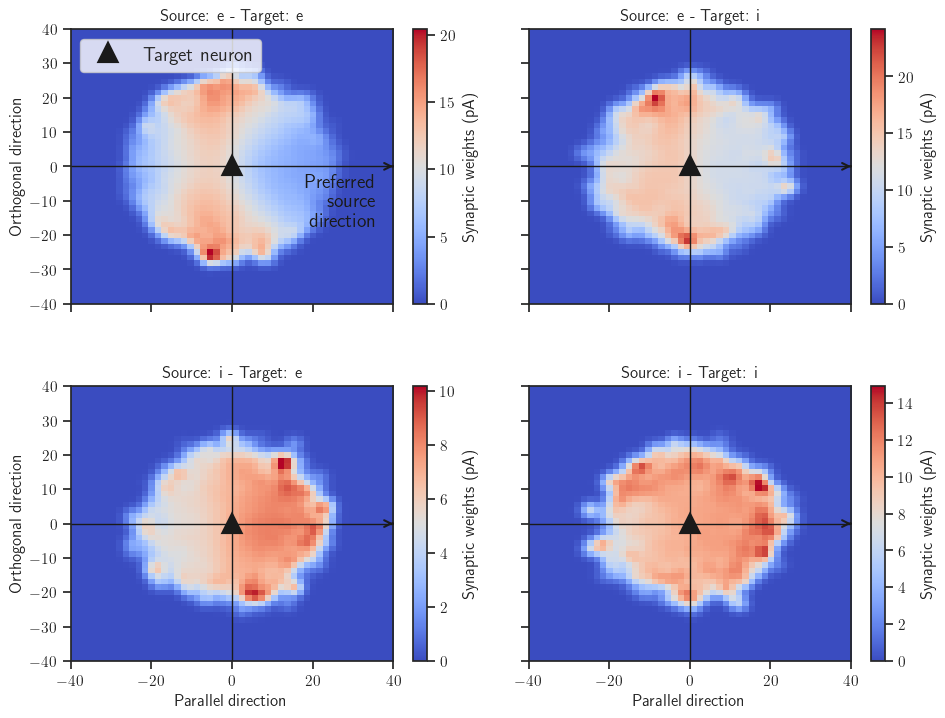

In [20]:
target_cell_types = ["e", "i"]
# target_cell_types = ['e5']
source_cell_types = ["e", "i"]
source_feature = "DSI"  # 'OSI'

fig = plt.figure(
    figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)),
    constrained_layout=True,
)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.8
gs = gridspec.GridSpec(
    len(source_cell_types),
    len(target_cell_types) + 1,
    width_ratios=[1, 1, 0.035],
    wspace=0.2,
    hspace=0.3,
    top=top_title_space,
)
# # Define limits of the histograms
# global_min = 0
# global_max = 20

plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)].astype(np.int32).values
    source_tf_ids = (
        df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # target_tf_ids = df.index[(df['pop_name'].str.contains(target_cell_type)) & (df['region'] == 'core') ].astype(np.int32).values
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = np.abs(
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, "preferred_angle"].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, "azimuth"].values
        target_azimuth = df.loc[target_indices, "azimuth"].values
        source_elevation = df.loc[source_indices, "elevation"].values
        target_elevation = df.loc[target_indices, "elevation"].values
        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # # rotate to the axis of target neuron tuning angle
        source_tuning_angle_rad = np.radians(source_tuning_angles)
        cos_angles = np.cos(source_tuning_angle_rad)
        sin_angles = np.sin(source_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        bins = 50
        # area_dimensions = [[-80, 80], [-80, 80]]
        area_dimensions = [[-40, 40], [-40, 40]]
        # area_dimensions = [[-10, 10], [-10, 10]]

        hist, xedges_parallel, yedges_parallel = np.histogram2d(
            diff_x_rot,
            diff_z_rot,
            bins=bins,
            range=area_dimensions,
            weights=final_value_masked,
        )
        count_hist, _, _ = np.histogram2d(
            diff_x_rot, diff_z_rot, range=area_dimensions, bins=bins
        )
        hist = np.divide(
            hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0
        )
        # Apply Gaussian filter to histograms
        sigma = 1
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        ax = plt.subplot(gs[row, col])
        im_filtered = ax.imshow(
            hist_filtered.T,
            origin="lower",
            extent=[
                xedges_parallel[0],
                xedges_parallel[-1],
                yedges_parallel[0],
                yedges_parallel[-1],
            ],
            aspect="auto",
            cmap="coolwarm",
        )  # , vmin=global_min, vmax=global_max)
        ax.axhline(0, color="k", lw=1)
        ax.axvline(0, color="k", lw=1)
        ax.annotate(
            "",
            xy=(ax.get_xlim()[1], 0),
            xytext=(ax.get_xlim()[1] - 0.1, 0),
            arrowprops=dict(arrowstyle="->", color="k", lw=1.5),
        )
        cbar = plt.colorbar(im_filtered, ax=ax)
        cbar.set_label("Synaptic weights (pA)")
        if col == 0:
            ax.set_ylabel("Orthogonal direction", fontsize=12)
        if col != 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        if row == len(source_cell_types) - 1:
            ax.set_xlabel("Parallel direction")
        else:
            plt.setp(ax.get_xticklabels(), visible=False)

        ax.plot(0, 0, "k^", markersize=12, markeredgewidth=3, label="Target neuron")
        if plot_index == 0:
            # Position for the centered text at the right end of the x-axis
            x_right = x_right = ax.get_xlim()[1] - 0.05 * (
                ax.get_xlim()[1] - ax.get_xlim()[0]
            )  # Move left by 10% of x-axis range
            y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.text(
                x_right,
                y_position,
                "Preferred \n source \n direction",
                color="k",
                ha="right",
                va="top",
                fontsize=14,
                weight="bold",
            )
            ax.legend(loc="upper left", fontsize=14)

        ax.set_title(f"Source: {source_cell_type} - Target: {target_cell_type}")
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.show()

/allen/programs/mindscope/workgroups/realistic-model/beatriz.herrera/miniconda3/envs/v1-SstTac1-model-PSS-tf/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


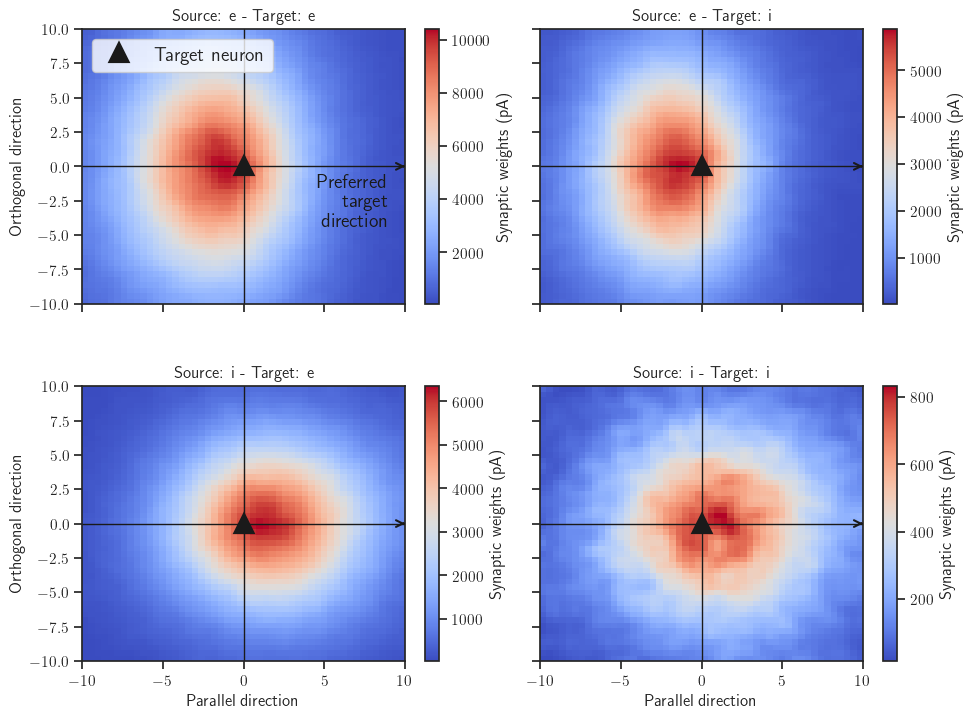

In [21]:
target_cell_types = ["e", "i"]
source_cell_types = ["e", "i"]
source_feature = "DSI"  # 'OSI'

fig = plt.figure(
    figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)),
    constrained_layout=True,
)
if len(source_cell_types) * len(target_cell_types) == 4:
    top_title_space = 0.9
else:
    top_title_space = 0.8
gs = gridspec.GridSpec(
    len(source_cell_types),
    len(target_cell_types) + 1,
    width_ratios=[1, 1, 0.035],
    wspace=0.2,
    hspace=0.3,
    top=top_title_space,
)
# Define limits of the histograms
# global_min = 0
# global_max = 20

plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    # Select source and target IDs
    # source_tf_ids = df.index[(df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)].astype(np.int32).values
    source_tf_ids = (
        df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = np.abs(
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # Calculate tuning angle differences
        # source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, "azimuth"].values
        target_azimuth = df.loc[target_indices, "azimuth"].values
        source_elevation = df.loc[source_indices, "elevation"].values
        target_elevation = df.loc[target_indices, "elevation"].values

        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # get the target neuron angle to define the rotation
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        bins = 50
        # data_2d = np.column_stack((diff_azimuth_rot, diff_elevation_rot))
        # bins_x, bins_y = utils.freedman_diaconis_bin_sizes(data_2d, returnas="bins")
        # area_dimensions = [[-40, 40], [-40, 40]]
        area_dimensions = [[-10, 10], [-10, 10]]

        hist, xedges_parallel, yedges_parallel = np.histogram2d(
            diff_x_rot,
            diff_z_rot,
            bins=bins,
            range=area_dimensions,
            weights=final_value_masked,
        )
        count_hist, _, _ = np.histogram2d(
            diff_x_rot, diff_z_rot, range=area_dimensions, bins=bins
        )
        # hist, xedges_parallel, yedges_parallel = np.histogram2d(diff_azimuth_rot, diff_elevation_rot, bins=[bins_x, bins_y], range=area_dimensions, weights=final_value_masked)
        # count_hist, _, _ = np.histogram2d(diff_azimuth_rot, diff_elevation_rot, range=area_dimensions, bins=[bins_x, bins_y])

        # hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
        # Apply Gaussian filter to histograms
        sigma = 1
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        ax = plt.subplot(gs[row, col])
        im_filtered = ax.imshow(
            hist_filtered.T,
            origin="lower",
            extent=[
                xedges_parallel[0],
                xedges_parallel[-1],
                yedges_parallel[0],
                yedges_parallel[-1],
            ],
            aspect="auto",
            cmap="coolwarm",
        )  # , vmin=7, vmax=11
        ax.axhline(0, color="k", lw=1)
        ax.axvline(0, color="k", lw=1)
        ax.annotate(
            "",
            xy=(ax.get_xlim()[1], 0),
            xytext=(ax.get_xlim()[1] - 0.1, 0),
            arrowprops=dict(arrowstyle="->", color="k", lw=1.5),
        )
        cbar = plt.colorbar(im_filtered, ax=ax)
        cbar.set_label("Synaptic weights (pA)")
        if col == 0:
            ax.set_ylabel("Orthogonal direction", fontsize=12)
        if col != 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        if row == len(source_cell_types) - 1:
            ax.set_xlabel("Parallel direction")
        else:
            plt.setp(ax.get_xticklabels(), visible=False)

        ax.plot(0, 0, "k^", markersize=12, markeredgewidth=3, label="Target neuron")
        if plot_index == 0:
            # Position for the centered text at the right end of the x-axis
            x_right = x_right = ax.get_xlim()[1] - 0.05 * (
                ax.get_xlim()[1] - ax.get_xlim()[0]
            )  # Move left by 10% of x-axis range
            y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.text(
                x_right,
                y_position,
                "Preferred \n target \n direction",
                color="k",
                ha="right",
                va="top",
                fontsize=14,
                weight="bold",
            )
            ax.legend(loc="upper left", fontsize=14)

        ax.set_title(f"Source: {source_cell_type} - Target: {target_cell_type}")
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.show()

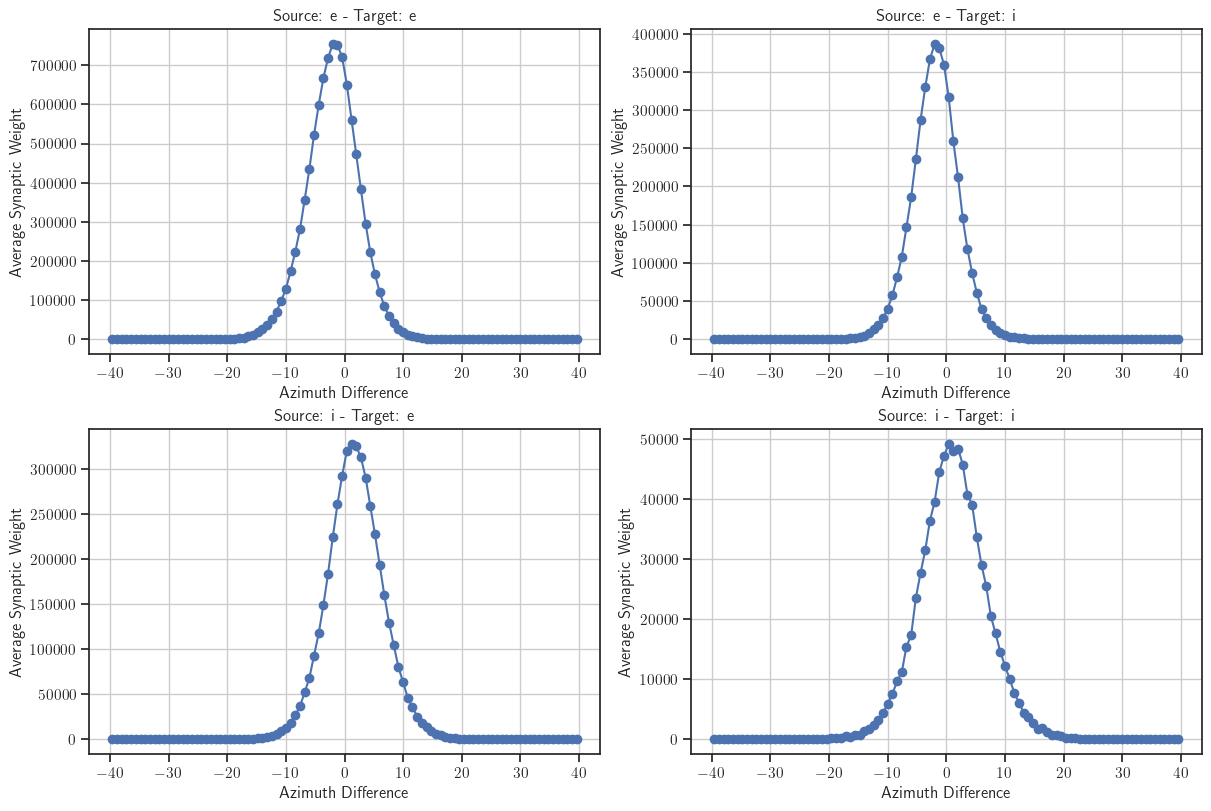

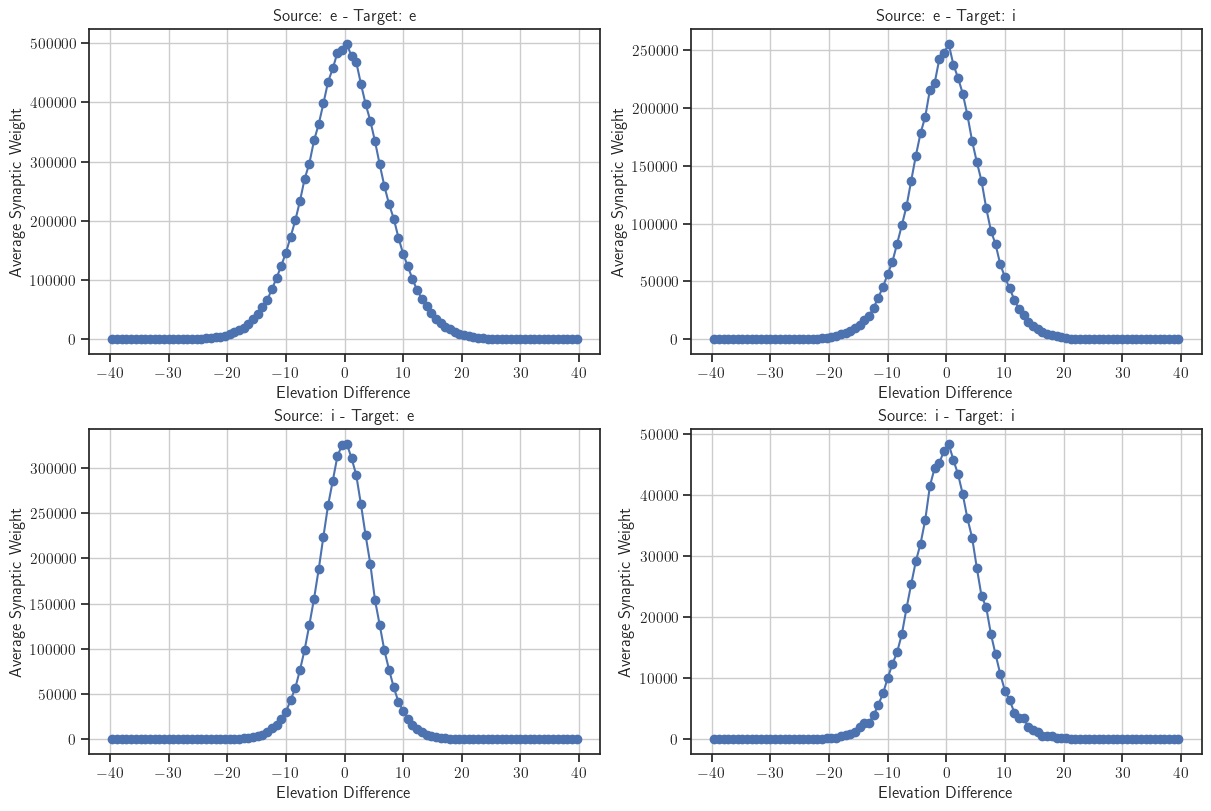

In [22]:
target_cell_types = ["e", "i"]
source_cell_types = ["e", "i"]
source_feature = "DSI"  # 'OSI'

# Create figures for azimuth and elevation
fig_azimuth = plt.figure(
    figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)),
    constrained_layout=True,
)
fig_elevation = plt.figure(
    figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)),
    constrained_layout=True,
)

# Create gridspecs
gs_azimuth = gridspec.GridSpec(
    len(source_cell_types), len(target_cell_types), figure=fig_azimuth
)
gs_elevation = gridspec.GridSpec(
    len(source_cell_types), len(target_cell_types), figure=fig_elevation
)

# Define bins and area dimensions
bins = 100
area_dimensions = [[-40, 40], [-40, 40]]  # Adjust as needed

for row, source_cell_type in enumerate(source_cell_types):
    # Select source IDs
    # source_tf_ids = df.index[
    #     (df['ei'] == source_cell_type) & (df['region'] == 'core') & (df[source_feature] > 0.2)
    # ].astype(np.int32).values
    source_tf_ids = (
        df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        # Select target IDs
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )

        # Create masks and select indices
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]

        # Get synaptic weights
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        final_value_masked = np.abs(
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )

        # Calculate differences in coordinates
        # source_tuning_angles = df.loc[source_indices, 'preferred_angle'].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        source_azimuth = df.loc[source_indices, "azimuth"].values
        target_azimuth = df.loc[target_indices, "azimuth"].values
        source_elevation = df.loc[source_indices, "elevation"].values
        target_elevation = df.loc[target_indices, "elevation"].values

        # source position in the target centered coordinate system
        diff_azimuth = source_azimuth - target_azimuth
        diff_elevation = source_elevation - target_elevation
        # # rotate to the axis of target neuron tuning angle
        target_tuning_angle_rad = np.radians(target_tuning_angles)
        cos_angles = np.cos(target_tuning_angle_rad)
        sin_angles = np.sin(target_tuning_angle_rad)
        # Rotate the sources coordinates according to the target neuron preferred direction
        diff_x_rot = diff_azimuth * cos_angles + diff_elevation * sin_angles
        diff_z_rot = diff_elevation * cos_angles - diff_azimuth * sin_angles

        # Compute histograms for azimuth differences
        hist_x_sum, bin_edges_x = np.histogram(
            diff_x_rot, bins=bins, range=area_dimensions[0], weights=final_value_masked
        )
        hist_x_count, _ = np.histogram(diff_x_rot, bins=bins, range=area_dimensions[0])
        hist_x_avg = np.divide(
            hist_x_sum,
            hist_x_count,
            out=np.zeros_like(hist_x_sum),
            where=hist_x_count != 0,
        )
        bin_centers_x = (bin_edges_x[:-1] + bin_edges_x[1:]) / 2

        # Compute histograms for elevation differences
        hist_z_sum, bin_edges_z = np.histogram(
            diff_z_rot, bins=bins, range=area_dimensions[1], weights=final_value_masked
        )
        hist_z_count, _ = np.histogram(diff_z_rot, bins=bins, range=area_dimensions[1])
        hist_z_avg = np.divide(
            hist_z_sum,
            hist_z_count,
            out=np.zeros_like(hist_z_sum),
            where=hist_z_count != 0,
        )
        bin_centers_z = (bin_edges_z[:-1] + bin_edges_z[1:]) / 2

        # Plot azimuth marginal distribution
        ax_azimuth = fig_azimuth.add_subplot(gs_azimuth[row, col])
        ax_azimuth.plot(bin_centers_x, hist_x_sum, marker="o", linestyle="-")
        ax_azimuth.set_xlabel("Azimuth Difference")
        ax_azimuth.set_ylabel("Average Synaptic Weight")
        ax_azimuth.set_title(f"Source: {source_cell_type} - Target: {target_cell_type}")
        ax_azimuth.grid(True)

        # Plot elevation marginal distribution
        ax_elevation = fig_elevation.add_subplot(gs_elevation[row, col])
        ax_elevation.plot(bin_centers_z, hist_z_sum, marker="o", linestyle="-")
        ax_elevation.set_xlabel("Elevation Difference")
        ax_elevation.set_ylabel("Average Synaptic Weight")
        ax_elevation.set_title(
            f"Source: {source_cell_type} - Target: {target_cell_type}"
        )
        ax_elevation.grid(True)

plt.show()

## SYNAPSES SCATTERING (CONNECTIONS AND WEIGHTS) IN AZIMUTH AND ELEVATION

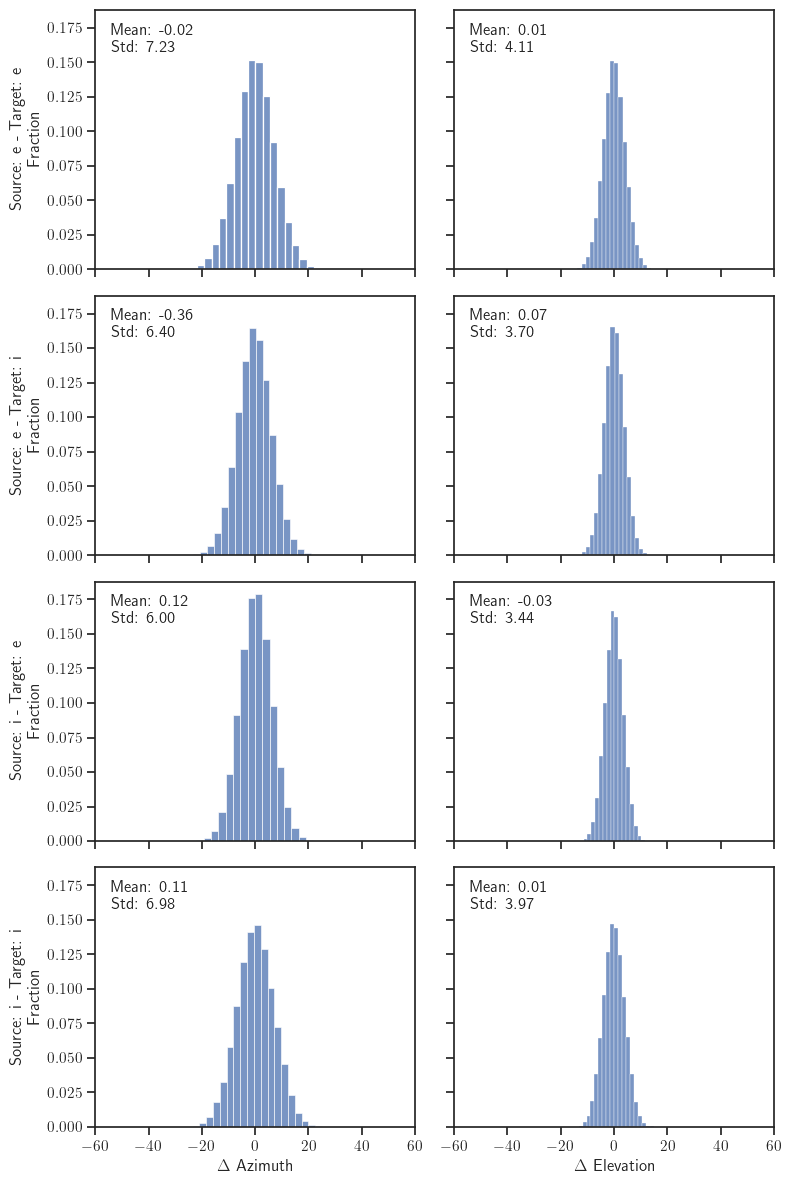

In [23]:
target_cell_types = ["e", "i"]
source_cell_types = ["e", "i"]

fig, axs = plt.subplots(
    len(source_cell_types) * len(target_cell_types),
    2,
    figsize=(8, 6 * len(source_cell_types)),
    sharex=True,
    sharey=True,
)
# axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    for col, target_cell_type in enumerate(target_cell_types):
        source_tf_ids = (
            df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, "azimuth"].values
        target_azimuth = df.loc[target_indices, "azimuth"].values
        source_elevation = df.loc[source_indices, "elevation"].values
        target_elevation = df.loc[target_indices, "elevation"].values
        diff_x = source_azimuth - target_azimuth
        diff_z = source_elevation - target_elevation
        # Calculate statistics
        mean_diff_x = np.mean(diff_x)
        std_diff_x = np.std(diff_x)
        mean_diff_z = np.mean(diff_z)
        std_diff_z = np.std(diff_z)
        # Plot the distributions of diff x and diff z
        sns.histplot(diff_x, stat="proportion", bins=20, ax=axs[plot_index, 0])
        axs[plot_index, 0].set_xlim(-60, 60)
        axs[plot_index, 0].set_xlabel(r"$\Delta$ Azimuth")
        axs[plot_index, 0].set_ylabel(
            f"Source: {source_cell_type} - Target: {target_cell_type}\n Fraction"
        )
        axs[plot_index, 0].text(
            0.05,
            0.95,
            f"Mean: {mean_diff_x:.2f}\nStd: {std_diff_x:.2f}",
            transform=axs[plot_index, 0].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )
        sns.histplot(diff_z, stat="proportion", bins=20, ax=axs[plot_index, 1])
        axs[plot_index, 1].set_xlim(-60, 60)
        axs[plot_index, 1].set_xlabel(r"$\Delta$ Elevation")
        axs[plot_index, 1].set_ylabel("Fraction")
        axs[plot_index, 1].text(
            0.05,
            0.95,
            f"Mean: {mean_diff_z:.2f}\nStd: {std_diff_z:.2f}",
            transform=axs[plot_index, 1].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.tight_layout()

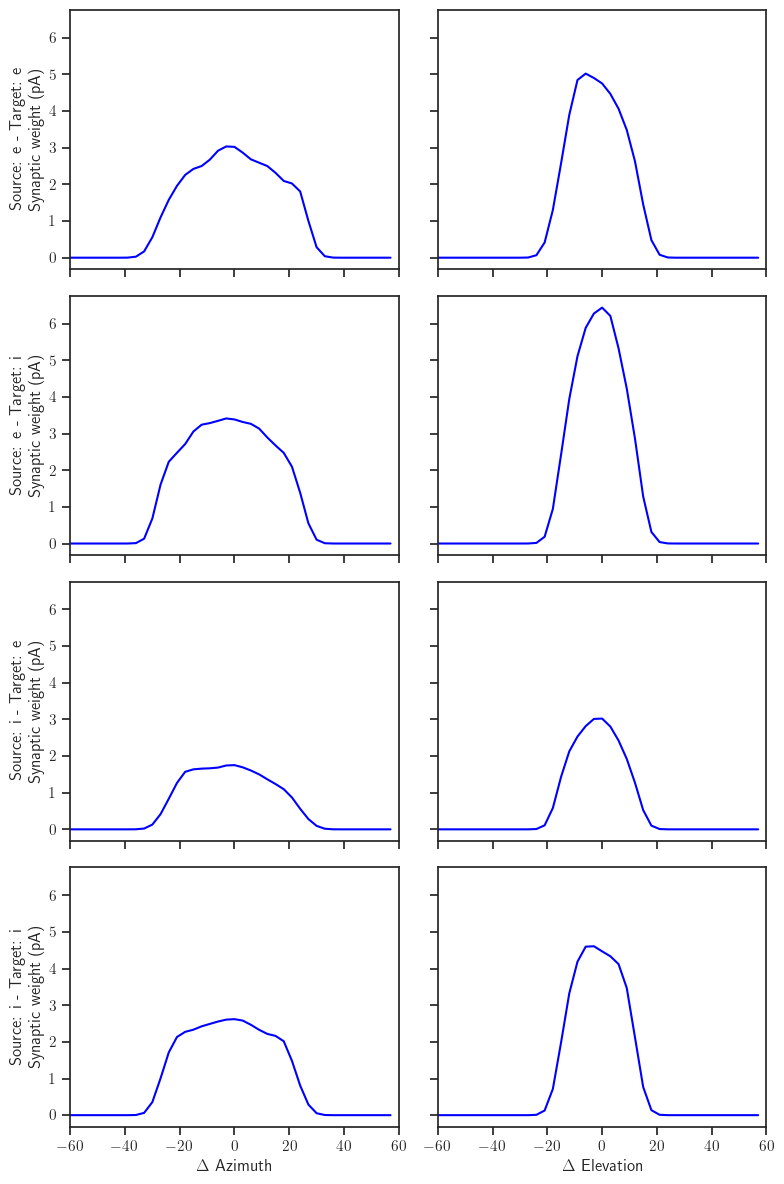

In [24]:
cell_types = ["e", "i"]
source_cell_types = ["e", "i"]

fig, axs = plt.subplots(
    len(source_cell_types) * len(cell_types),
    2,
    figsize=(8, 6 * len(source_cell_types)),
    sharex=True,
    sharey=True,
)
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = (
        df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(cell_types):
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = np.abs(
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = np.abs(
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # # Calculate tuning angle differences
        # source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
        # target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
        # tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        # tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
        # Calculate differences in coordinates
        source_azimuth = df.loc[source_indices, "azimuth"].values
        target_azimuth = df.loc[target_indices, "azimuth"].values
        source_elevation = df.loc[source_indices, "elevation"].values
        target_elevation = df.loc[target_indices, "elevation"].values
        diff_x = source_azimuth - target_azimuth
        diff_z = source_elevation - target_elevation
        # target_tuning_angle_rad = np.radians(target_tuning_angles[selected_indices[:, 0]])
        # diff_x_rot = diff_x * np.cos(target_tuning_angle_rad+np.pi) + diff_z * np.sin(target_tuning_angle_rad+np.pi)
        # diff_z_rot = diff_z * np.cos(target_tuning_angle_rad+np.pi) - diff_x * np.sin(target_tuning_angle_rad+np.pi)
        bins = 40
        area_dimensions = [[-60, 60], [-60, 60]]
        hist, xedges_final, yedges_final = np.histogram2d(
            diff_z, diff_x, bins=bins, range=area_dimensions, weights=final_value_masked
        )
        count_hist, _, _ = np.histogram2d(
            diff_z, diff_x, range=area_dimensions, bins=bins
        )
        hist = np.divide(
            hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0
        )
        # Apply Gaussian filter to histograms
        sigma = 1
        hist_filtered = gaussian_filter(hist, sigma=sigma)
        # Calculate Marginal Distributions
        marginal_final_x = np.mean(hist_filtered, axis=0)
        marginal_final_z = np.mean(hist_filtered, axis=1)
        # Plot the distribution of marginal_final_x and marginal_final_z
        axs[plot_index, 0].plot(xedges_final[:-1], marginal_final_x, color="blue")
        axs[plot_index, 0].set_xlim(-60, 60)
        axs[plot_index, 0].set_ylabel(
            f"Source: {source_cell_type} - Target: {target_cell_type}\n Synaptic weight (pA)"
        )
        axs[plot_index, 1].plot(yedges_final[:-1], marginal_final_z, color="blue")
        axs[plot_index, 1].set_xlim(-60, 60)
        plot_index += 1

axs[plot_index - 1, 0].set_xlabel(r"$\Delta$ Azimuth")
axs[plot_index - 1, 1].set_xlabel(r"$\Delta$ Elevation")
# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.tight_layout()
plt.show()

## OSI/DSI ANALYSIS AND LIKE-LIKE RULES

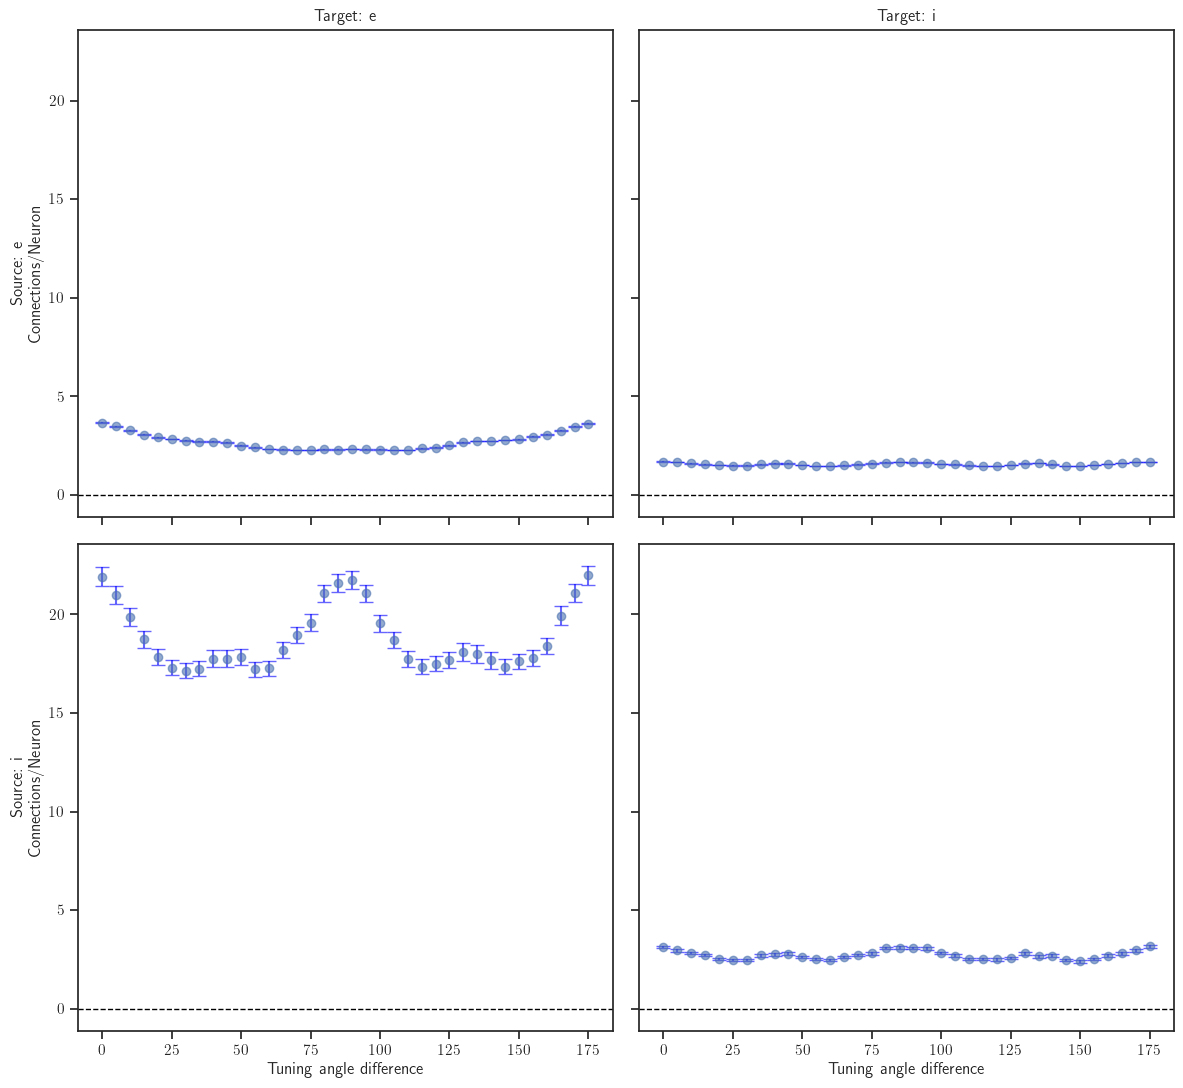

In [25]:
# %%timeit
areas = ["v1", "lm"]
target_cell_types = ["e", "i"]
source_cell_types = ["e", "i"]

fig, axs = plt.subplots(
    len(source_cell_types),
    len(target_cell_types),
    figsize=(12, 6 * len(source_cell_types)),
    sharex=True,
    sharey=True,
)
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = df.index[(df["ei"] == source_cell_type)].astype(np.int32).values
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, "preferred_angle"].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        bins = np.arange(0, 181, 5)
        bin_counts = np.zeros(len(bins) - 1)
        bin_errors = np.zeros(len(bins) - 1)
        bin_indices = np.digitize(tuning_angle_diff, bins) - 1
        # Loop over the bins to calculate mean connections per neuron and their errors
        for i in range(len(bins) - 1):
            # Get the connections that fall into the current bin
            connections_in_bin = selected_indices[bin_indices == i]

            if connections_in_bin.size > 0:
                # Unique source neurons and counts in the current bin
                unique_source_neurons, neuron_indices, counts = np.unique(
                    connections_in_bin[:, 1], return_inverse=True, return_counts=True
                )
                num_neurons_in_bin = unique_source_neurons.size

                if num_neurons_in_bin > 0:
                    # Calculate mean and error for the bin using NumPy operations
                    bin_counts[i] = np.mean(counts)
                    # Calculate the standard deviation and SEM for the bin
                    std_dev = np.std(
                        counts, ddof=1
                    )  # ddof=1 for sample standard deviation
                    bin_errors[i] = std_dev / np.sqrt(num_neurons_in_bin)

        # Plot the histogram
        axs[plot_index].errorbar(
            bins[:-1],
            bin_counts,
            yerr=bin_errors,
            fmt="o",
            ecolor="blue",
            capsize=5,
            label="Connections/Neuron",
            alpha=0.6,
        )
        axs[plot_index].axhline(y=0, color="black", linestyle="--", linewidth=1)

        if row == 0:
            axs[plot_index].set_title(f"Target: {target_cell_type}", fontsize=12)
        if col == 0:
            axs[plot_index].set_ylabel(
                f"Source: {source_cell_type}\nConnections/Neuron", fontsize=12
            )
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(f"Tuning angle difference", fontsize=12)

        # axs[plot_index].grid(True)
        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

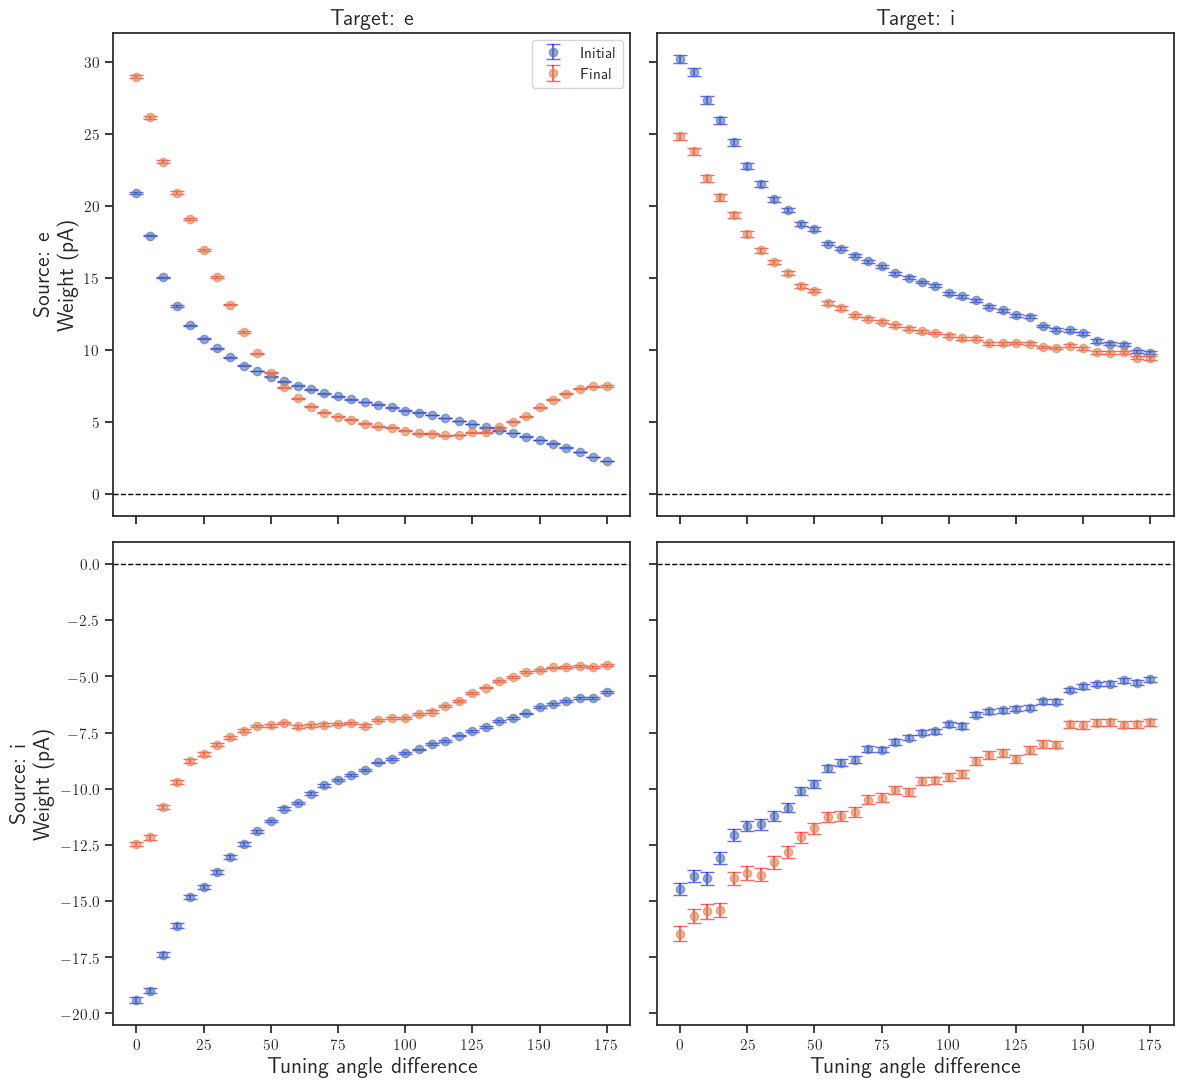

In [26]:
target_cell_types = ["e", "i"]
source_cell_types = ["e", "i"]

fig, axs = plt.subplots(
    len(source_cell_types),
    len(target_cell_types),
    figsize=(12, 6 * len(source_cell_types)),
    sharex=True,
    sharey="row",
)
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = (
        df.index[(df["ei"] == source_cell_type) & (df["region"] == "core")]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[(df["ei"] == target_cell_type) & (df["region"] == "core")]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = (
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = (
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, "preferred_angle"].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        bins = np.arange(0, 181, 5)
        bin_indices = np.digitize(tuning_angle_diff, bins)
        bin_initial_values = np.zeros(len(bins) - 1)
        bin_initial_errors = np.zeros(len(bins) - 1)
        bin_final_values = np.zeros(len(bins) - 1)
        bin_final_errors = np.zeros(len(bins) - 1)
        for i in range(1, len(bins)):
            initial_values_in_bin = initial_value_masked[bin_indices == i]
            if initial_values_in_bin.size > 0:
                bin_initial_values[i - 1] = np.mean(initial_values_in_bin)
                std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                bin_initial_errors[i - 1] = std_dev_initial / np.sqrt(
                    initial_values_in_bin.size
                )

            final_values_in_bin = final_value_masked[bin_indices == i]
            if final_values_in_bin.size > 0:
                bin_final_values[i - 1] = np.mean(final_values_in_bin)
                std_dev_final = np.std(final_values_in_bin, ddof=1)
                bin_final_errors[i - 1] = std_dev_final / np.sqrt(
                    final_values_in_bin.size
                )

        axs[plot_index].errorbar(
            bins[:-1],
            bin_initial_values,
            yerr=bin_initial_errors,
            fmt="o",
            ecolor="blue",
            capsize=5,
            label="Initial",
            alpha=0.6,
        )
        axs[plot_index].errorbar(
            bins[:-1],
            bin_final_values,
            yerr=bin_final_errors,
            fmt="o",
            ecolor="red",
            capsize=5,
            label="Final",
            alpha=0.6,
        )
        axs[plot_index].axhline(y=0, color="black", linestyle="--", linewidth=1)

        if row == 0:
            axs[plot_index].set_title(f"Target: {target_cell_type}", fontsize=16)
        if col == 0:
            axs[plot_index].set_ylabel(
                f"Source: {source_cell_type}\nWeight (pA)", fontsize=16
            )
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(r"Tuning angle difference", fontsize=16)
        if row == 0 and col == 0:
            axs[plot_index].legend()

        plot_index += 1

# fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

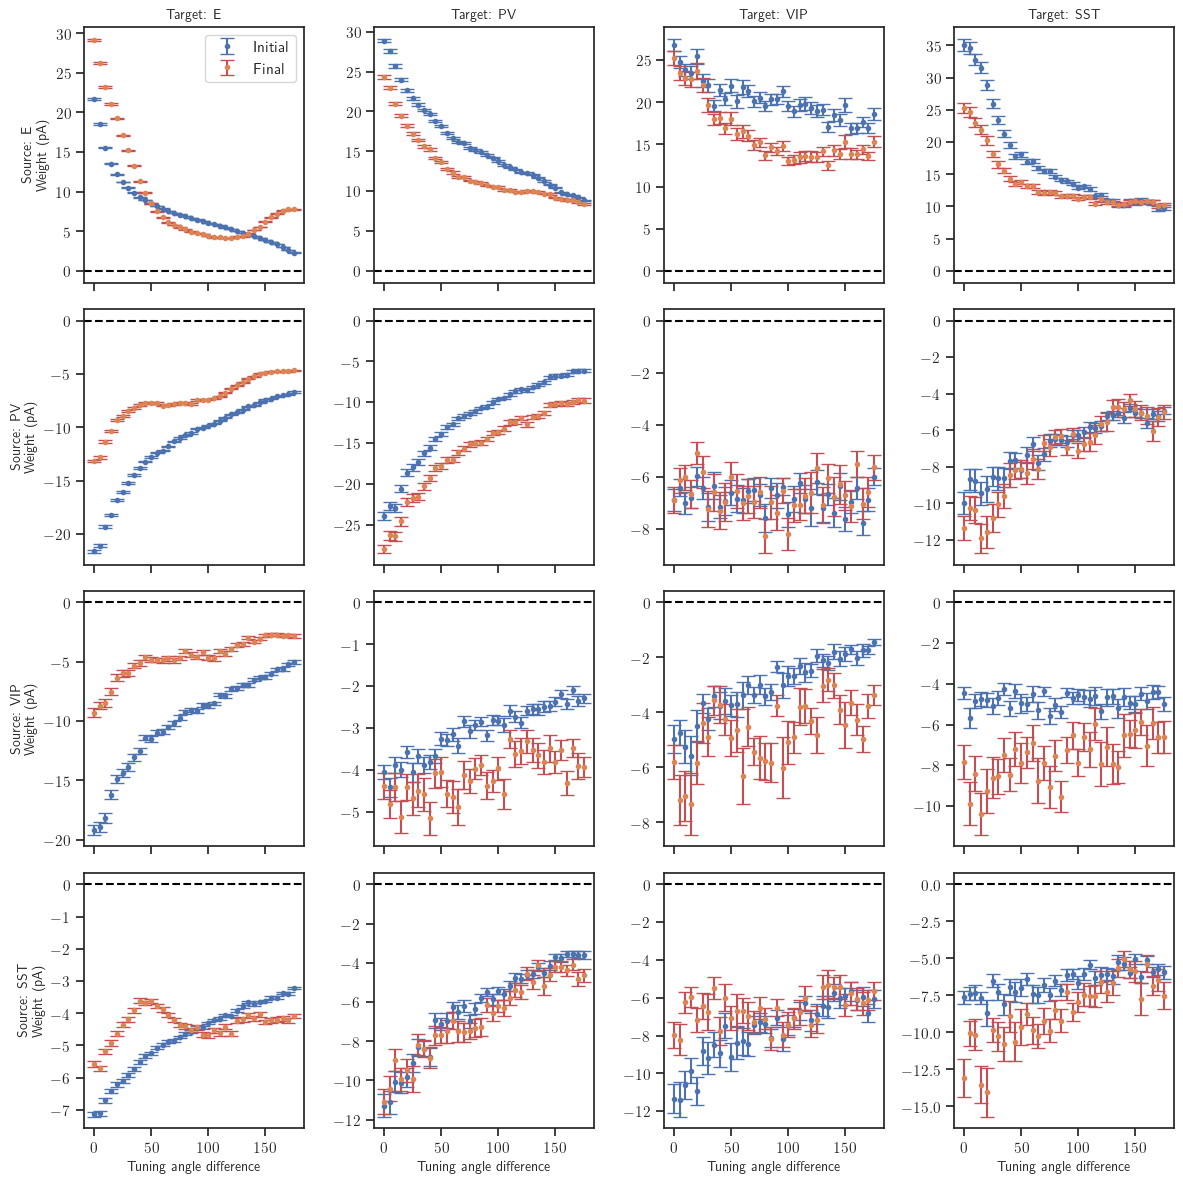

In [27]:
target_cell_types = [
    "E",
    "PV",
    "VIP",
    "SST",
]  # ['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
source_cell_types = ["E", "PV", "VIP", "SST"]
# target_cell_types = ['E', 'IT', 'NP', 'PV', 'Htr3a', 'VIP', 'SST'] #['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
# source_cell_types = ['E', 'IT', 'NP', 'PV', 'Htr3a', 'VIP', 'SST'] #['E', 'PV', 'VIP', 'SST']
num_subplots = len(source_cell_types)

fig, axs = plt.subplots(
    len(source_cell_types),
    len(target_cell_types),
    figsize=(12, 3 * len(source_cell_types)),
    sharex=True,
)  # , sharey='row')
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = (
        df.index[
            (df["cell_type"].str.contains(source_cell_type)) & (df["region"] == "core")
        ]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[
                (df["cell_type"].str.contains(target_cell_type))
                & (df["region"] == "core")
            ]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = (
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = (
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, "preferred_angle"].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        # take bins of 1 degree and average the weight values in the corresponding bin
        bins = np.arange(0, 181, 5)
        bin_indices = np.digitize(tuning_angle_diff, bins)
        bin_initial_values = np.zeros(len(bins) - 1)
        bin_initial_errors = np.zeros(
            len(bins) - 1
        )  # Array to store the standard error of the mean for each bin
        bin_final_values = np.zeros(len(bins) - 1)
        bin_final_errors = np.zeros(
            len(bins) - 1
        )  # Array to store the standard error of the mean for each bin
        for i in range(1, len(bins)):
            initial_values_in_bin = initial_value_masked[bin_indices == i]
            if initial_values_in_bin.size > 0:
                bin_initial_values[i - 1] = np.mean(initial_values_in_bin)
                std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                bin_initial_errors[i - 1] = std_dev_initial / np.sqrt(
                    initial_values_in_bin.size
                )

            final_values_in_bin = final_value_masked[bin_indices == i]
            if final_values_in_bin.size > 0:
                bin_final_values[i - 1] = np.mean(final_values_in_bin)
                std_dev_final = np.std(final_values_in_bin, ddof=1)
                bin_final_errors[i - 1] = std_dev_final / np.sqrt(
                    final_values_in_bin.size
                )

        # plot the average weight values with error bars
        axs[plot_index].errorbar(
            bins[:-1],
            bin_initial_values,
            yerr=bin_initial_errors,
            fmt=".",
            ecolor="b",
            capsize=5,
            label="Initial",
        )
        axs[plot_index].errorbar(
            bins[:-1],
            bin_final_values,
            yerr=bin_final_errors,
            fmt=".",
            ecolor="r",
            capsize=5,
            label=f"Final",
        )
        axs[plot_index].axhline(y=0, color="black", linestyle="--")
        if row == 0:
            axs[plot_index].set_title(f"Target: {target_cell_type}", fontsize=10)
        if col == 0:
            axs[plot_index].set_ylabel(
                f"Source: {source_cell_type}\n Weight (pA)", fontsize=10
            )  # , rotation=0, labelpad=40)
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(r"Tuning angle difference", fontsize=10)
        if row == 0 and col == 0:
            axs[plot_index].legend()
        plot_index += 1

# fig.suptitle(f'Src Area: {source_area}, Tgt Area: {target_area}')
plt.tight_layout()
plt.show()

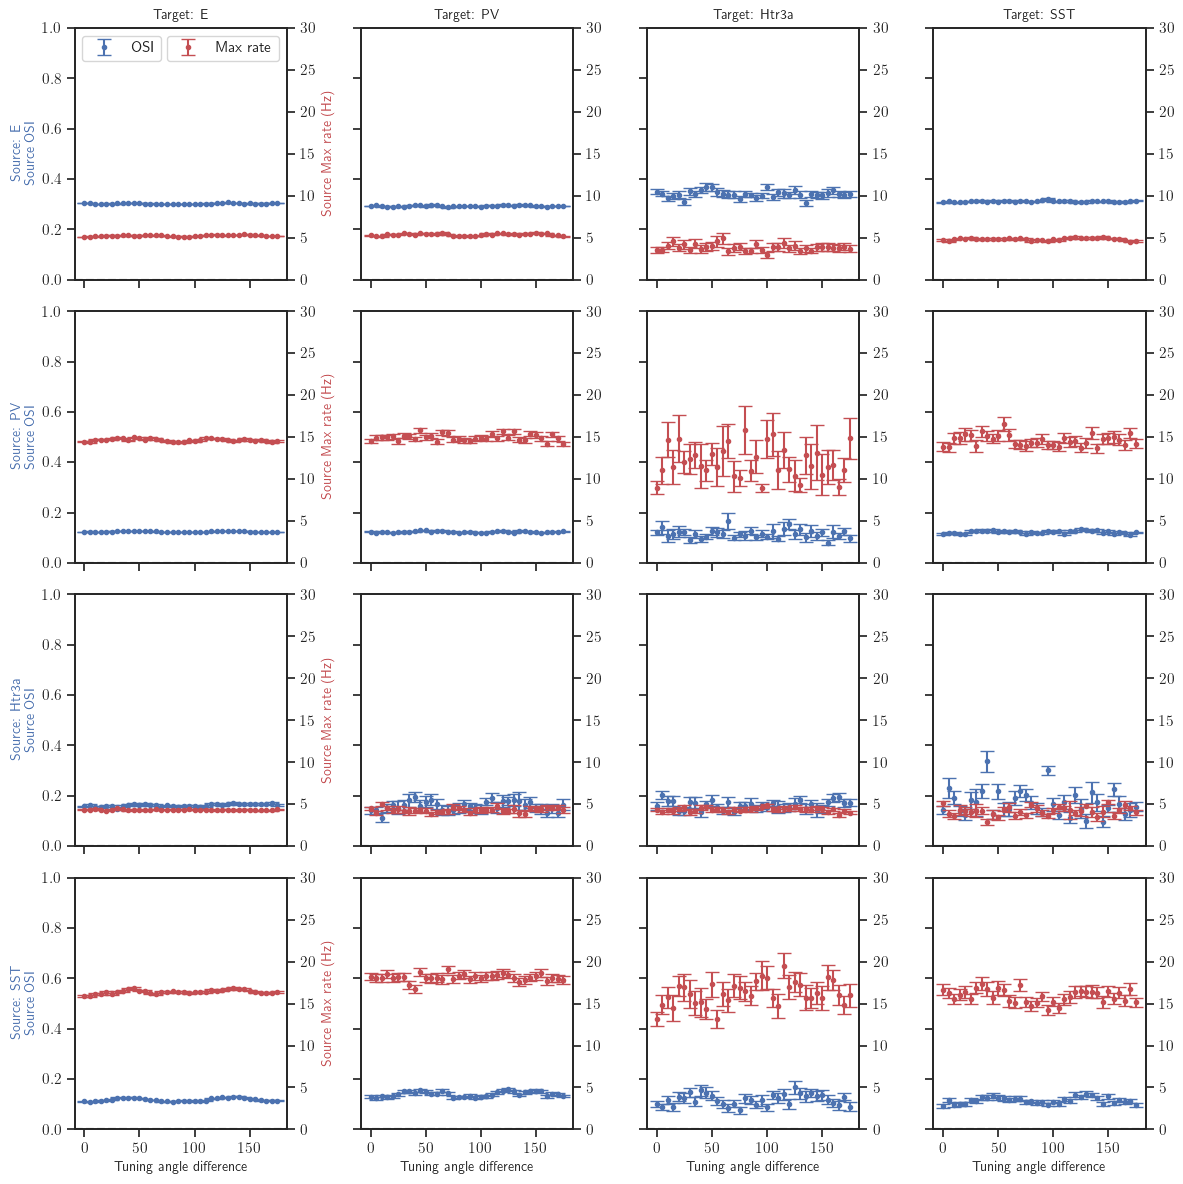

In [28]:
target_cell_types = [
    "E",
    "PV",
    "Htr3a",
    "SST",
]  # ['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
source_cell_types = ["E", "PV", "Htr3a", "SST"]
num_subplots = len(source_cell_types)

fig, axs = plt.subplots(
    len(source_cell_types),
    4,
    figsize=(12, 3 * len(source_cell_types)),
    sharex=True,
    sharey="row",
)
axs = axs.flatten()
plot_index = 0
for row, source_cell_type in enumerate(source_cell_types):
    source_tf_ids = (
        df.index[
            (df["cell_type"].str.contains(source_cell_type)) & (df["region"] == "core")
        ]
        .astype(np.int32)
        .values
    )
    for col, target_cell_type in enumerate(target_cell_types):
        target_tf_ids = (
            df.index[
                (df["cell_type"].str.contains(target_cell_type))
                & (df["region"] == "core")
            ]
            .astype(np.int32)
            .values
        )
        # Create sets for fast lookup
        mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
        selected_indices = indices[mask]
        target_indices = selected_indices[:, 0]
        source_indices = selected_indices[:, 1]
        source_osi = df.loc[source_indices, "OSI"].values
        source_max_fr = df.loc[source_indices, "max_mean_rate(Hz)"].values
        # Mask voltage_scale_node_ids first
        voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
        initial_value_masked = (
            model_variables_dict["Initial"][variable_key][mask] * voltage_scale_node_ids
        )
        final_value_masked = (
            model_variables_dict["Restored"][variable_key][mask]
            * voltage_scale_node_ids
        )
        # Calculate tuning angle differences
        source_tuning_angles = df.loc[source_indices, "preferred_angle"].values
        target_tuning_angles = df.loc[target_indices, "preferred_angle"].values
        tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
        tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

        # take bins of 1 degree and average the weight values in the corresponding bin
        bins = np.arange(0, 181, 5)
        bin_indices = np.digitize(tuning_angle_diff, bins)
        bin_initial_values = np.zeros(len(bins) - 1)
        bin_initial_errors = np.zeros(
            len(bins) - 1
        )  # Array to store the standard error of the mean for each bin
        bin_final_values = np.zeros(len(bins) - 1)
        bin_final_errors = np.zeros(
            len(bins) - 1
        )  # Array to store the standard error of the mean for each bin
        for i in range(1, len(bins)):
            max_fr_values_in_bin = source_max_fr[bin_indices == i]
            if max_fr_values_in_bin.size > 0:
                bin_initial_values[i - 1] = np.mean(max_fr_values_in_bin)
                std_dev_initial = np.std(max_fr_values_in_bin, ddof=1)
                bin_initial_errors[i - 1] = std_dev_initial / np.sqrt(
                    max_fr_values_in_bin.size
                )

            osi_values_in_bin = source_osi[bin_indices == i]
            if osi_values_in_bin.size > 0:
                bin_final_values[i - 1] = np.mean(osi_values_in_bin)
                std_dev_final = np.std(osi_values_in_bin, ddof=1)
                bin_final_errors[i - 1] = std_dev_final / np.sqrt(
                    osi_values_in_bin.size
                )

        # plot the average weight values with error bars
        axs[plot_index].errorbar(
            bins[:-1],
            bin_final_values,
            yerr=bin_final_errors,
            fmt=".",
            color="b",
            capsize=5,
            label="OSI",
        )
        # Create a second y-axis for initial_values
        ax2 = axs[plot_index].twinx()
        ax2.errorbar(
            bins[:-1],
            bin_initial_values,
            yerr=bin_initial_errors,
            fmt=".",
            color="r",
            capsize=5,
            label=f"Max rate",
        )
        axs[plot_index].axhline(y=0, color="black", linestyle="--")
        axs[plot_index].set_ylim(0, 1)
        ax2.set_ylim(0, 30)
        if row == 0:
            axs[plot_index].set_title(f"Target: {target_cell_type}", fontsize=10)
        if col == 0:
            axs[plot_index].set_ylabel(
                f"Source: {source_cell_type} \n Source OSI", fontsize=10, color="b"
            )  # , rotation=0, labelpad=40)
            ax2.set_ylabel(f"Source Max rate (Hz)", fontsize=10, color="r")
        if row == len(source_cell_types) - 1:
            axs[plot_index].set_xlabel(r"Tuning angle difference", fontsize=10)
        if row == 0 and col == 0:
            axs[plot_index].legend(loc="upper left")
            ax2.legend(loc="upper right")
        plot_index += 1

# fig.suptitle(f'Src Area: {source_area}, Tgt Area: {target_area}')
plt.tight_layout()
plt.show()